# Test new model

In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.attention import BiasAtMF
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 64
model = BiasAtMF(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 64, learning_rate: 0.01, weight_decay: 1e-05


## Train

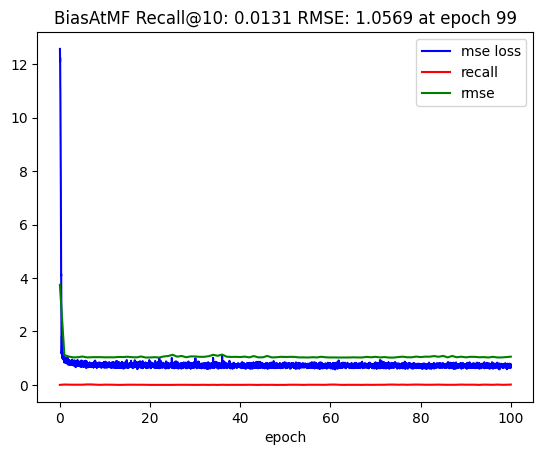

BiasAtMF Recall@10: 0.0131 RMSE: 1.0569 at epoch 99


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 100
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'BiasAtMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'BiasAtMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

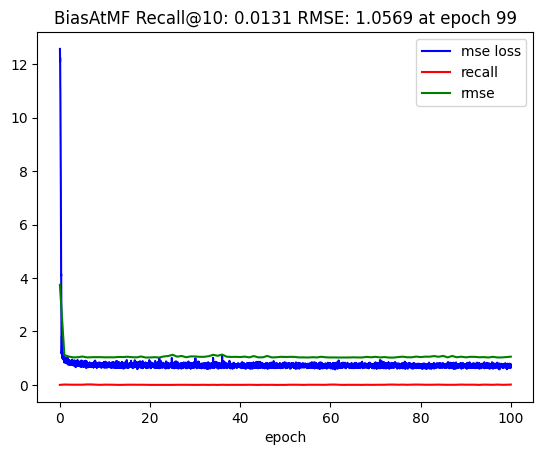

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'BiasAtMF Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/BiasAtMF Embed_dim: {n_factors} Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [8]:
recall_list

[0.001639344262295082,
 0.014754098360655738,
 0.009836065573770493,
 0.00819672131147541,
 0.00819672131147541,
 0.00819672131147541,
 0.018032786885245903,
 0.018032786885245903,
 0.00819672131147541,
 0.003278688524590164,
 0.009836065573770493,
 0.00819672131147541,
 0.006557377049180328,
 0.001639344262295082,
 0.003278688524590164,
 0.00819672131147541,
 0.00819672131147541,
 0.006557377049180328,
 0.006557377049180328,
 0.004918032786885246,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.001639344262295082,
 0.004918032786885246,
 0.004918032786885246,
 0.004918032786885246,
 0.003278688524590164,
 0.001639344262295082,
 0.003278688524590164,
 0.004918032786885246,
 0.0,
 0.004918032786885246,
 0.0,
 0.006557377049180328,
 0.001639344262295082,
 0.003278688524590164,
 0.003278688524590164,
 0.003278688524590164,
 0.003278688524590164,
 0.006557377049180328,
 0.003278688524590164,
 0.0,
 0.004918032786885246,


In [9]:
rmse_list

[3.7458574938534186,
 1.1166867287574906,
 1.0595914073900983,
 1.0303326775030317,
 1.0374541490833198,
 1.0629446557782576,
 1.0300424615199995,
 1.0359549266333306,
 1.0392618203260615,
 1.039328232823846,
 1.0318041959577804,
 1.034687900756279,
 1.032080864706361,
 1.0471960685650354,
 1.0427606496475152,
 1.053325989331425,
 1.0381848637122146,
 1.0305487242372573,
 1.0640700464639243,
 1.026035650916626,
 1.0271063700807772,
 1.0381841747636473,
 1.024421451858329,
 1.0637600103281586,
 1.0813268027839433,
 1.1266732488154019,
 1.0575557560572397,
 1.0843282068363762,
 1.0349275156338085,
 1.0674441809432598,
 1.0655381578426868,
 1.0505841719156361,
 1.052178400610429,
 1.0739724171575575,
 1.1260091176417668,
 1.0911101500048768,
 1.1338255463216451,
 1.056126947401836,
 1.046512142324198,
 1.0504581564477333,
 1.0427292681004714,
 1.0591233396234625,
 1.0306340892569077,
 1.0795799058226447,
 1.0308891011672083,
 1.0337856215551793,
 1.083885999459876,
 1.0286422471897372,
 1

In [10]:
# max(recall_list), min(rmse_list) 
print(f'BiasAtMF Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'BiasAtMF Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

BiasAtMF Max Recall@10: 0.0180 at epoch 6
BiasAtMF Min RMSE: 1.0225 at epoch 74
